### **Imports**

In [2]:
import pandas as pd
from sklearn import model_selection
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.applications.imagenet_utils import preprocess_input
from keras.regularizers import *
import cv2
# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)


Using TensorFlow backend.


### **Mount & set directory**


In [8]:
from google.colab import drive
from sklearn.utils import shuffle

drive.mount('/content/drive')
home_dir = '/content/drive/My Drive/Colab Notebooks/FER/'
baum_dir = home_dir + 'BAUM/'
data = pd.read_csv(baum_dir + 'training_data_mixed.csv', dtype={'flow': str, 'spatial': str, 'code': str})
data_valid = pd.read_csv(baum_dir + 'validation_data_mixed.csv', dtype={'flow': str, 'spatial': str, 'code': str})

data = shuffle(data)
data_valid = shuffle(data_valid)

#data = data[:4000]
#data_valid = data_valid[:2000]


# drop odd elements
#data = data.iloc[range(0,len(data),2)]
#data_valid = data_valid.iloc[range(0,len(data_valid),2)]

#print (data.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Data Analysis and Visualization**

Unique classes are:  ['2', '3', '4', '5', '1', '6']
0.25.3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.


['Happiness', 'Disgust', 'Surprise', 'Sadness', 'Sadness']
['Fear', 'Happiness', 'Happiness', 'Fear', 'Disgust']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.


['Sadness', 'Sadness', 'Fear', 'sadness', 'Sadness']
['Happiness', 'Sadness', 'Anger', 'Sadness', 'Sadness']


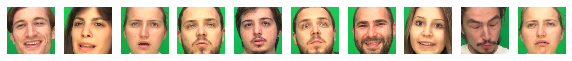

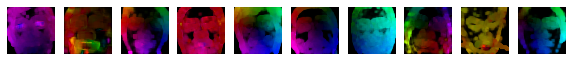

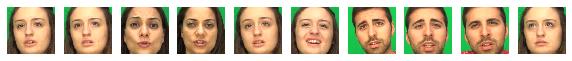

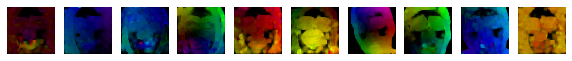

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
data_unique = data['code'].unique().tolist()
print("Unique classes are: ",data_unique)
print(pd.__version__)

images = []
images_flow = []
emotions = []
codes = []
i = 0
while i < 10:
  sample = data.sample()
  #print(type(sample))
  spatial = sample['spatial'] 
  #print(type(spatial))

  flow = sample['flow'] 
  emotion = sample['emotion'] 
  code = sample['code']
  spatial = spatial.get_values()[0]
  flow = flow.get_values()[0]
  emotion = emotion.get_values()[0]
  code = code.get_values()[0]
  img_path = baum_dir + spatial
  img_path_flow = baum_dir +flow
  if (os.path.isfile(img_path)):
    images.append(mpimg.imread(img_path))
    images_flow.append(mpimg.imread(img_path_flow))
    emotions.append(emotion)
    codes.append(code)
    i+=1

plt.figure(figsize=(10,15))
columns = 10

for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.axis('off')

print(emotions[:5])
print(emotions[5:])

plt.figure(figsize=(10,25))
plt.axis('off')
columns = 10

for i, image in enumerate(images_flow):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.axis('off')

images = []
images_flow = []
emotions = []
codes = []
i = 0
while i < 10:
  sample = data_valid.sample()
  #print(type(sample))
  spatial = sample['spatial'] 
  #print(type(spatial))

  flow = sample['flow'] 
  emotion = sample['emotion'] 
  code = sample['code']
  spatial = spatial.get_values()[0]
  flow = flow.get_values()[0]
  emotion = emotion.get_values()[0]
  code = code.get_values()[0]
  img_path = baum_dir + spatial
  img_path_flow = baum_dir +flow
  if (os.path.isfile(img_path)):
    images.append(mpimg.imread(img_path))
    images_flow.append(mpimg.imread(img_path_flow))
    emotions.append(emotion)
    codes.append(code)
    i+=1

plt.figure(figsize=(10,15))
columns = 10

for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.axis('off')

print(emotions[:5])
print(emotions[5:])

plt.figure(figsize=(10,25))
plt.axis('off')
columns = 10

for i, image in enumerate(images_flow):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.axis('off')



### **Image generators**

In [7]:
# The new approach data and data_valid are seperate csv files with different videos Use most of data(99%) and neglect the 1% 
'''
X_train, _, y_train, _ = model_selection.train_test_split(data['spatial'], data['code'], test_size=0.01)
_, X_test, _, y_test = model_selection.train_test_split(data_valid['spatial'], data_valid['code'], test_size=0.99)

X_train_flow, _, y_train_flow, _ = model_selection.train_test_split(data['flow'], data['code'], test_size=0.01)
_, X_test_flow, _, y_test_flow = model_selection.train_test_split(data_valid['flow'], data_valid['code'], test_size=0.99)
'''
#The old approach using same csv file
#X_train, X_test, y_train, y_test = model_selection.train_test_split(data['flow'], data['code'], test_size=0.25)
#X_train_flow, X_test_flow, y_train_flow, y_test_flow = model_selection.train_test_split(data['flow'], data['code'], test_size=0.25)

# Both approches has issues as train_test_split shuffles data(by default) , So we input a spatial image and a flow image with no relation with each other. 
X_train, X_train_flow, y_train = data['spatial'], data['flow'], data['code']
X_test, X_test_flow, y_test = data_valid['spatial'], data_valid['flow'], data_valid['code']




train_df = pd.concat([X_train, y_train], axis=1, sort=False)
train_df_flow = pd.concat([X_train_flow, y_train], axis=1, sort=False)
valid_df = pd.concat([X_test, y_test], axis=1, sort=False)
valid_df_flow = pd.concat([X_test_flow, y_test], axis=1, sort=False)

batch_size_ = 256

train_datagen = ImageDataGenerator(
        #rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator()#rescale=1./255)

train_generator_spatial = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        seed = 1,
        directory=baum_dir,
        x_col="spatial",
        y_col="code",
        target_size=(48, 48),
        batch_size=batch_size_,
        class_mode='categorical')

validation_generator_spatial = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        seed = 1,
        directory=baum_dir,
        x_col="spatial",
        y_col="code",
        target_size=(48, 48),
        batch_size=batch_size_,
        class_mode='categorical')

train_generator_flow = train_datagen.flow_from_dataframe(
        dataframe=train_df_flow,
        seed = 1,
        directory=baum_dir,
        x_col="flow",
        y_col="code",
        target_size=(48, 48),
        batch_size=batch_size_,
        class_mode='categorical')

validation_generator_flow = test_datagen.flow_from_dataframe(
        dataframe=valid_df_flow,
        seed = 1,
        directory=baum_dir,
        x_col="flow",
        y_col="code",
        target_size=(48, 48),
        batch_size=batch_size_,
        class_mode='categorical')

def combine_generator(gen1, gen2):
    while True:    
        X1i = gen1.next()
        X2i = gen2.next()
        #cv2.imshow(X1i[0])

        yield [X1i[0], X2i[0]], X1i[1]  #X1i[1] is the label


train_generator = combine_generator(train_generator_spatial, train_generator_flow)
validation_generator = combine_generator(validation_generator_spatial, validation_generator_flow)

print ("generators initiaized")

Found 4000 validated image filenames belonging to 6 classes.
Found 2000 validated image filenames belonging to 6 classes.
Found 4000 validated image filenames belonging to 6 classes.
Found 2000 validated image filenames belonging to 6 classes.
generators initiaized


### **Model & setting**

In [0]:

# Create Model
def create_model():
  input_spatial = Input(shape=(48,48,3))
  x = layers.Conv2D(64, (5, 5), activation='relu')(input_spatial)
  x = layers.MaxPooling2D(pool_size=(5,5), strides=(2, 2))(x)
  x = layers.Conv2D(64, (3, 3), activation='relu')(x)
  x = layers.Conv2D(64, (3, 3), activation='relu')(x)
  x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
  x = layers.Conv2D(128, (3, 3), activation='relu')(x)
  x = layers.Conv2D(128, (3, 3), activation='relu')(x)
  x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
  Out_spatial = layers.Flatten()(x)

  input_flow = Input(shape=(48,48,3))
  x = layers.Conv2D(64, (5, 5), activation='relu')(input_flow)
  x = layers.MaxPooling2D(pool_size=(5,5), strides=(2, 2))(x)
  x = layers.Conv2D(64, (3, 3), activation='relu')(x)
  x = layers.Conv2D(64, (3, 3), activation='relu')(x)
  x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
  x = layers.Conv2D(128, (3, 3), activation='relu')(x)
  x = layers.Conv2D(128, (3, 3), activation='relu')(x)
  x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
  Out_flow = layers.Flatten()(x)

  merged1=concatenate([Out_spatial, Out_flow])

  x = layers.Dense(1024, activation='relu')(merged1)
  x = layers.Dropout(0.4)(x)
  x = layers.Dense(1024, activation='relu',
                kernel_regularizer=l2(0.01),
                activity_regularizer=l1(0.01))(x)
  x = layers.Dropout(0.4)(x)
  Out = layers.Dense(6, activation='softmax')(x)

  model = models.Model(inputs=[input_spatial, input_flow], outputs=[Out])
  return model
  
model = create_model()
print (model.summary())

model.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 44, 44, 64)   4864        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 44, 44, 64)   4864        input_2[0][0]                    
_____________

### **Train**

In [0]:
# Add checkpoint for model saver
model_dir = baum_dir + 'Models/'
filepath=model_dir + 'Model_fusion_collab.h5'
checkpoint = ModelCheckpoint(filepath,
                             monitor = 'val_acc',
                             verbose = 1,
                             save_best_only = True,
                             mode = 'max')

callbacks_list = [checkpoint]
                             
# Train Model
model.fit_generator(
        train_generator,
        steps_per_epoch = 1000,
        epochs = 36,
        validation_data  = validation_generator,
        validation_steps = 400,
        callbacks = callbacks_list,)

Epoch 1/36
   3/1000 [..............................] - ETA: 60:09:33 - loss: 18.0408 - acc: 0.2526

### **End**